In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import sys
sys.path.append('../')

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=FutureWarning)

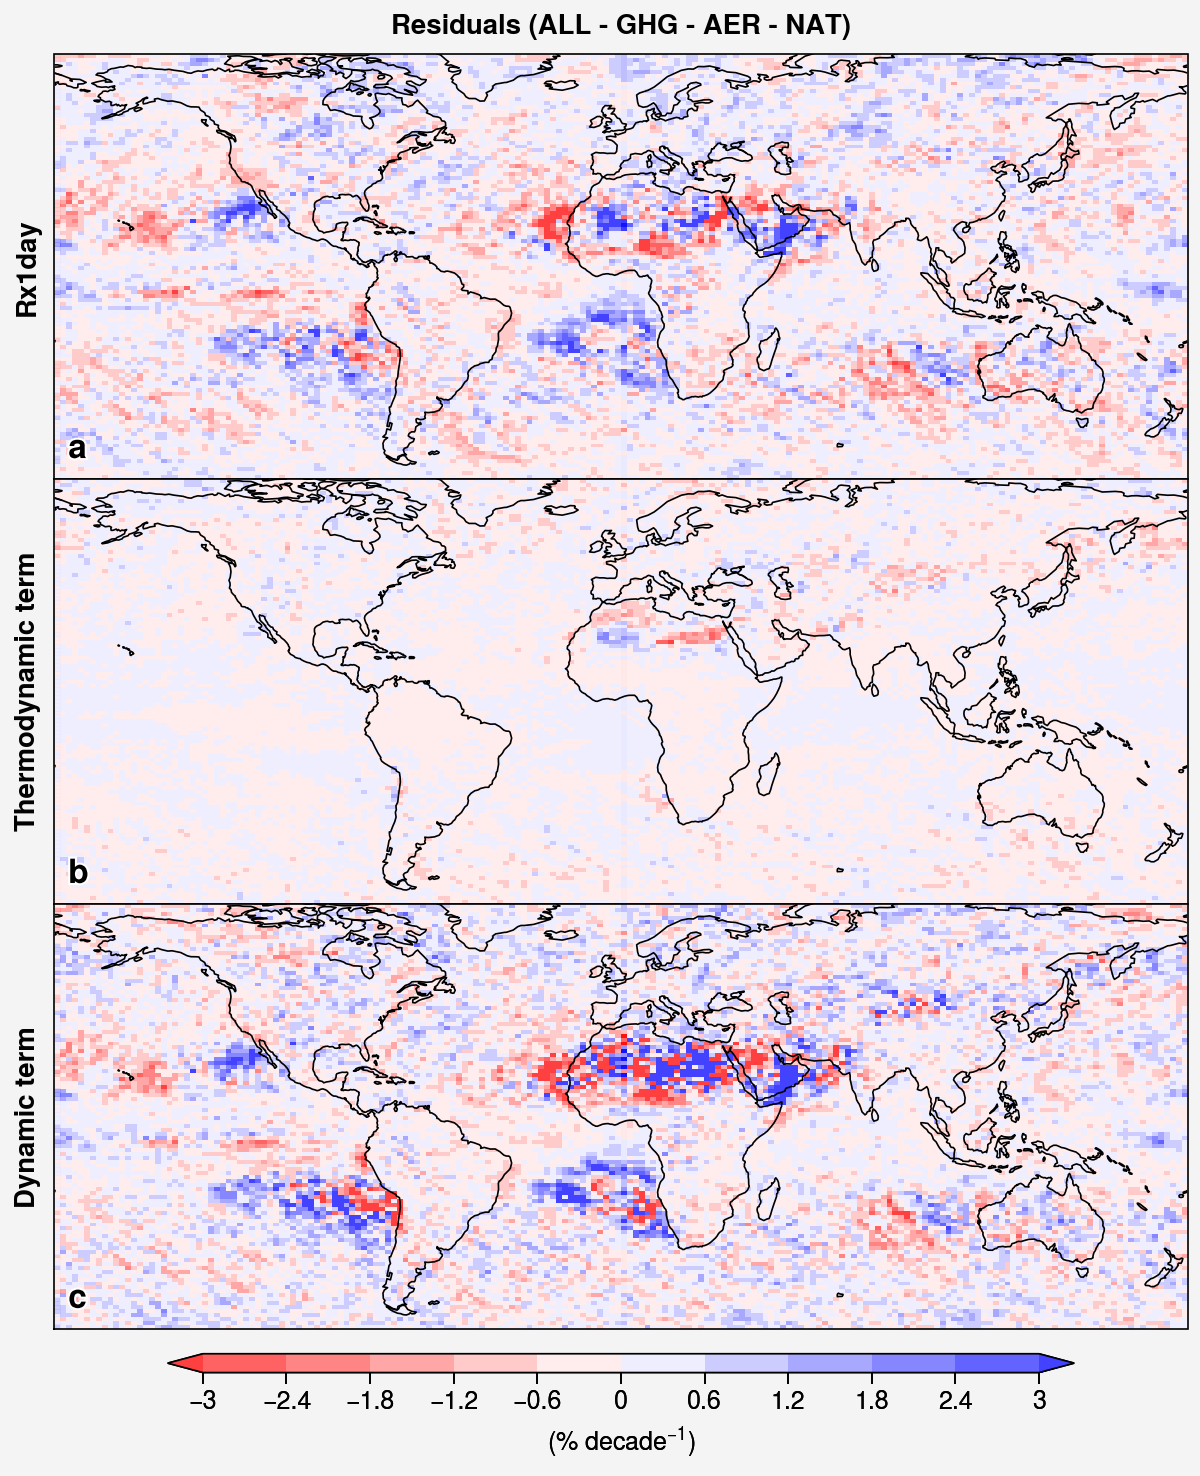

In [9]:
fig, axs = pplot.subplots(ncols=1,nrows=3,hspace=0,share=False,
                        proj='pcarree',width=6)
axs.format(grid=False)
axs.format(abc=True,abcsize=12,abcloc='ll')

vmax=3
vmin=-3
levels=11

forcing_list = ['historical','hist-GHG','hist-aer']
name_list    = ['prec','scaling_thermo','scaling_dynamic']
var_name = {
    'prec':'prec_cond',
    'tas':'tas_cond',
    'sat_thermo':'sat_thermo_cond',
    'wap_mean':'wap_mean_cond',
    'scaling':'scaling',
    'scaling_thermo':'scaling_thermo',
    'scaling_dynamic':'scaling_dynamic'
}

ax_locs  = {
            'prec':0,
            'scaling_thermo':1,
            'scaling_dynamic':2
            }

model_path   = {'historical':'historical','hist-aer':'aer','hist-GHG':'GHG','hist-nat':'nat'}

for n in name_list:
    name = n
    for f in forcing_list:
        ensemble = ensembles[f]
        ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[f] + name + '_day_' + i + '*.nc')]
        src_ids = [i.split('_')[0] for i in ensemble]
        src_ids = list(set(src_ids))
        src_id_num_all = len(src_ids)
        src_id_num = {src_ids[i]:0 for i in range(src_id_num_all)}
        mmm_slp = {src_ids[i]:0 for i in range(src_id_num_all)}
        for i in ensemble:
            src_id = i.split('_')[0]
            run    = i.split('_')[2]
            pi_time = i.split('_')[3]

            prec_ens_i  = Rx5dayCond('prec',f,src_id,run,mask='None',pi_time=pi_time)
            prec_ens_i_mean = prec_ens_i.multiyear_mean()

            ens_i  = Rx1dayCond(name,f,src_id,run,mask='None',pi_time=pi_time)
            ens_i_slp = ens_i.trend_cal() / prec_ens_i_mean * 100 * 10
            mmm_slp[src_id] = mmm_slp[src_id] + ens_i_slp
            src_id_num[src_id] = src_id_num[src_id] + 1
        
        for s in src_ids:
            mmm_slp[s] = mmm_slp[s] / src_id_num[s]
        mmm_slp = sum(mmm_slp.values()) / src_id_num_all
        mmm_slp = mmm_slp[var_name[name]]

        if f == 'historical':
            mmm_slp_all = mmm_slp
        elif f == 'hist-GHG':
            mmm_slp_GHG = mmm_slp
        elif f == 'hist-aer':
            mmm_slp_aer = mmm_slp

    lons = mmm_slp['lon']
    lats1d = mmm_slp['lat']
    data1  = mmm_slp_all - mmm_slp_GHG - mmm_slp_aer
    data1, lons1d = add_cyclic_point(data1, coord=lons)
    data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2

    ax_loc = ax_locs[n]
    p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'both',cmap=cmaps.MPL_bwr_r)
    
    axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

axs.format(leftlabels=('Rx1day','Thermodynamic term','Dynamic term'),toplabels=('Residuals (ALL - GHG - AER - NAT)',))

fig.colorbar(p,loc='b',width='0.75em',cols=(1),title='(% ${decade^{-1}}$)',length=0.8)
fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS5_attribution_residuals.pdf')
